In [1]:
import collections

import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2024-05-31 16:25:32.643618: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 16:25:32.777633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:25:32.777659: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:25:32.778150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 16:25:32.851448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 16:25:32.852567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
train_ds, val_ds = tfds.load('svhn_cropped', split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load('svhn_cropped', split='test')
len(train_ds), len(val_ds), len(test_ds)

(58606, 14651, 26032)

(<matplotlib.image.AxesImage at 0x7f30d875a210>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

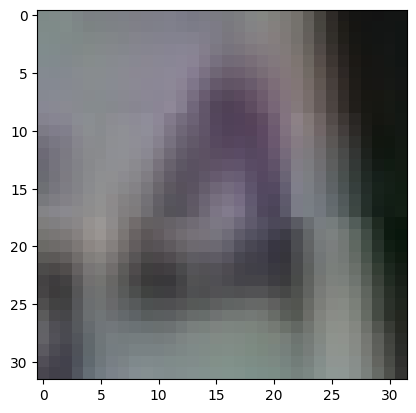

In [3]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [4]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.3, value_range=(0.,1.)),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomRotation(factor=(-0.3,0.3))

])

In [16]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            # .repeat(3)
            # .map(lambda x, y: (augmentation(x), y))  # augmentation doesn't really help
            .batch(512)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(512)
        )

In [17]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

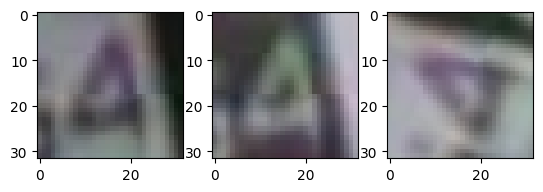

In [18]:
img = next(iter(train_ds))['image']
augmented_img = augmentation(tf.cast(img, dtype=tf.float32) / 255.)
fig, axes = plt.subplots(1,3)
axes[0].imshow(img)
axes[1].imshow(tf.image.adjust_contrast(img, -1.1))
axes[2].imshow(augmented_img)

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10),
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer, 
    loss=loss_object, 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

In [20]:
model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


115/115 [==============================] - 20s 173ms/step - loss: 2.1607 - accuracy: 0.2338 - val_loss: 1.8009 - val_accuracy: 0.4220
Epoch 2/10
115/115 [==============================] - 20s 171ms/step - loss: 1.3825 - accuracy: 0.5591 - val_loss: 0.9607 - val_accuracy: 0.7340
Epoch 3/10
115/115 [==============================] - 18s 153ms/step - loss: 0.9115 - accuracy: 0.7275 - val_loss: 0.6941 - val_accuracy: 0.8099
Epoch 4/10
115/115 [==============================] - 17s 145ms/step - loss: 0.7356 - accuracy: 0.7814 - val_loss: 0.6114 - val_accuracy: 0.8297
Epoch 5/10
115/115 [==============================] - 17s 146ms/step - loss: 0.6529 - accuracy: 0.8055 - val_loss: 0.5565 - val_accuracy: 0.8429
Epoch 6/10
115/115 [==============================] - 17s 150ms/step - loss: 0.6067 - accuracy: 0.8195 - val_loss: 0.5360 - val_accuracy: 0.8507
Epoch 7/10
115/115 [==============================] - 17s 148ms/step - loss: 0.5684 - accuracy: 0.8288 - val_loss: 0.5068 - val_accuracy: 0.8

In [21]:
model.evaluate(test)

51/51 [==============================] - 2s 32ms/step - loss: 0.5106 - accuracy: 0.8550


[0.5106485486030579, 0.8550245761871338]

: 